In [ ]:
# Calculating Rate per Link
* import libraries
* create the RSE to site mapping
* get the data +/- 5 days
* calculate the rates per link
* plot plot plot

In [1]:
#matplotlib stuff
%matplotlib inline
import matplotlib
matplotlib.rc('font', **{'size': 12})

# other imports
import datetime
from elasticsearch import Elasticsearch, helpers
from elasticsearch.helpers import scan
import datetime as dt
import json
import numpy as np
import pandas as pd
import pickle
import requests
import time

In [2]:
# Get AGIS endpoints (RSEs) and site names
r = requests.get('http://atlas-agis-api.cern.ch/request/site/query/list/ddmendpoints?json')
j = r.json()
#Create RSE to site name dictionary
rse2site = {}
for i in j:
    for ep in i['ddmendpoints']:
        rse2site[ep]=i['name']

#### Get transfers from ElasticSearch for the date DATE+/-DELTA days

In [3]:
es = Elasticsearch([{'host':'atlas-kibana.mwt2.org', 'port':9200}],timeout=60)
DATE = '2017-02-01'  # yyyy-mm-dd
DELTA = 5
# Generate the indexes to scan
dt.datetime.strptime(DATE,'%Y-%m-%d')
index_list = []
for i in range(-DELTA, DELTA+1):
    index_list.append('fts_'+(dt.datetime.strptime(DATE,'%Y-%m-%d')
                      + dt.timedelta(days=i)).strftime('%Y-%m-%d'))
indexes = ','.join(index_list)

In [4]:
period_start = dt.datetime.strptime(DATE,'%Y-%m-%d')
period_end = dt.datetime.strptime(DATE,'%Y-%m-%d') + dt.timedelta(days=1)
transfer_query = {
    "size": 0,
    "_source": ["src_rse", "dst_rse", "activity","bytes","submitted_at","started_at","transferred_at"],
    'query':{
        "bool" : {
            "must" : [
                {"range" : {"transferred_at" : {  "gte": period_start } }},
                {"range" : {"submitted_at" :   {  "lt" : period_end } }}
                ]
        }
    }
                
}
data=[]
scroll = scan(client=es, index=indexes, query=transfer_query, scroll='5m', timeout="5m", size=10000)
epoch = dt.datetime(1970,1,1)
st = time.time()
count = 0
for res in scroll:
    r = res['_source']
    # filter only the transfers between DATE and DATE+1day
    #if (dt.datetime.strptime(r['submitted_at'].strip('Z').split('.')[0], '%Y-%m-%dT%H:%M:%S') < dt.datetime.strptime(DATE,'%Y-%m-%d'))or(dt.datetime.strptime(r['transferred_at'].strip('Z').split('.')[0], '%Y-%m-%dT%H:%M:%S') > (dt.datetime.strptime(DATE,'%Y-%m-%d')+dt.timedelta(days=1))):
    #    continue
    r['submitted_at'] = (dt.datetime.strptime(r['submitted_at'].strip('Z').split('.')[0], '%Y-%m-%dT%H:%M:%S') - epoch).total_seconds()
    r['started_at'] = (dt.datetime.strptime(r['started_at'].strip('Z').split('.')[0], '%Y-%m-%dT%H:%M:%S') - epoch).total_seconds()
    r['transferred_at'] = (dt.datetime.strptime(r['transferred_at'].strip('Z').split('.')[0], '%Y-%m-%dT%H:%M:%S') - epoch).total_seconds()
    data.append([r['src_rse'],r['dst_rse'],r['activity'],r['bytes'],r['submitted_at'],r['started_at'],r['transferred_at']])
    count += 1
    if not count%100000 : print (count)
print('Reading took',time.time() - st,'seconds.')
data = pd.DataFrame(data, columns=['SRC', 'DST', 'ACT', 'SIZE', 'SUBMITTED', 'STARTED', 'ENDED'])
#data['QUEUE_T'] = data.STARTED - data.SUBMITTED
#data['NET_T'] = data.ENDED - data.STARTED
data['RATE'] = data.SIZE / (data.ENDED - data.STARTED)
src_sites = [rse2site[rse] for rse in data.SRC.values]
dst_sites = [rse2site[rse] for rse in data.DST.values]
data['SRC_SITE'] = src_sites
data['DST_SITE'] = dst_sites
print('Documents:', len(data))

100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000
1300000
1400000
1500000
1600000
1700000
1800000
1900000
Reading took 220.83852982521057 seconds.
Documents: 1961719


#### Calculate some stats for CERN - BNL Link

In [5]:
cut = data.where(data.SRC_SITE == 'CERN-PROD').dropna()
cut = cut.where(cut.DST_SITE == 'BNL-ATLAS').dropna()
pd.set_option('display.float_format', lambda x: '%.02f' % x)
cut.describe()

,SIZE,SUBMITTED,STARTED,ENDED,RATE
count,4490.00,4490.00,4490.00,4490.00,4490.00
mean,1221775312.41,1485935096.56,1485936092.96,1485936167.28,13773465.91
std,1118060738.12,23578.56,23069.70,23039.70,13136140.76
min,14718.00,1485907336.00,1485907346.00,1485907352.00,3679.50
25%,3404551.25,1485920531.00,1485921999.00,1485922116.50,573682.00
50%,952712462.00,1485921142.00,1485924200.00,1485924312.00,11446946.49
75%,2621324729.00,1485942283.75,1485942325.75,1485942384.00,22794421.37
max,5557670401.00,1485993128.00,1485993156.00,1485993161.00,83352864.10


In [6]:
cut = data.where(data.DST_SITE == 'CERN-PROD').dropna()
cut = cut.where(cut.SRC_SITE == 'BNL-ATLAS').dropna()
pd.set_option('display.float_format', lambda x: '%.02f' % x)
cut.describe()

,SIZE,SUBMITTED,STARTED,ENDED,RATE
count,25257.00,25257.00,25257.00,25257.00,25257.00
mean,142482863.82,1485956041.57,1485956403.98,1485956424.07,6454191.35
std,249344700.03,22957.61,22884.41,22880.78,8291434.67
min,338338.00,1485794399.00,1485907338.00,1485907393.00,28338.96
25%,2054640.00,1485943001.00,1485943561.00,1485943578.00,307364.80
50%,39135462.00,1485959731.00,1485959738.00,1485959744.00,3891078.43
75%,178055163.00,1485973949.00,1485974083.00,1485974101.00,8544582.34
max,6027243527.00,1485993525.00,1485993528.00,1485993534.00,71710538.46


#### Calculate the rates per minute

In [7]:
delta = (dt.datetime.strptime(DATE, '%Y-%m-%d') - epoch).total_seconds()
src_rate = {}
link_rate = {}
dst_rate = {}
src_files = {}
link_files = {}
dst_files = {}

st = time.time()
for row in data.itertuples():
    src = rse2site[row.SRC]
    link = rse2site[row.SRC]+'__'+rse2site[row.DST]
    dst = rse2site[row.DST]
    start = int((row.STARTED - delta)/60)
    end = int((row.ENDED - delta)/60)
    if src not in src_rate.keys():
        src_rate[src] = [0]*1440
        src_files[src] = [0]*1440
    if link not in link_rate.keys():
        link_rate[link] = [0]*1440
        link_files[link] = [0]*1440
    if dst not in dst_rate.keys():
        dst_rate[dst] = [0] * 1440
        dst_files[dst] = [0] * 1440
    scaled_rate = row.RATE * ((row.ENDED-row.STARTED)/((end+1 - start)*60))
    for i in range(start, end+1):
        if i < 0 or i >= 1440:
            continue
        else:
            src_rate[src][i] += scaled_rate
            link_rate[link][i] += scaled_rate
            dst_rate[dst][i] += scaled_rate
            src_files[src][i] += 1
            link_files[link][i] += 1
            dst_files[dst][i] += 1
print(time.time() - st)

/home/ivukotic/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:25: RuntimeWarning: invalid value encountered in double_scalars


28.24041199684143


### Plot for CERN / BNL Link

In [8]:
# the date index is from delta to delta+1 day in seconds.
date_index = range(int(delta), int(delta)+24*60*60, 60)
date_index = list(map(dt.datetime.utcfromtimestamp,date_index))

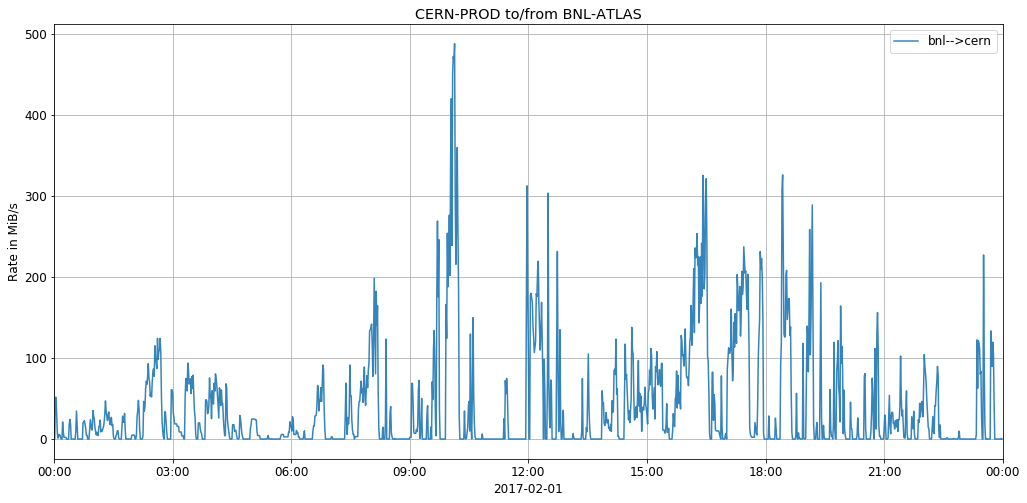

In [12]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
#fig, ax = plt.subplots()
plt.title('CERN-PROD to/from BNL-ATLAS')
plt.plot(date_index, np.array(link_rate['BNL-ATLAS__CERN-PROD'])/(1024*1024),'', alpha=0.9, label='bnl-->cern')
#plt.plot(date_index, -np.array(link_rate['CERN-PROD__BNL-ATLAS'])/(1024*1024),'', alpha=0.9, label='cern-->bnl')
#plt.yscale('log')
plt.xlim(dt.datetime.utcfromtimestamp(delta),dt.datetime.utcfromtimestamp(delta+24*60*60))
#plt.ylim(-100,100)
plt.xlabel(DATE)
plt.ylabel('Rate in MiB/s')
ax=plt.gca()
xfmt = mdates.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(xfmt)
fig = plt.gcf()
fig.set_size_inches(17, 8)
plt.legend()
plt.grid()
plt.show()

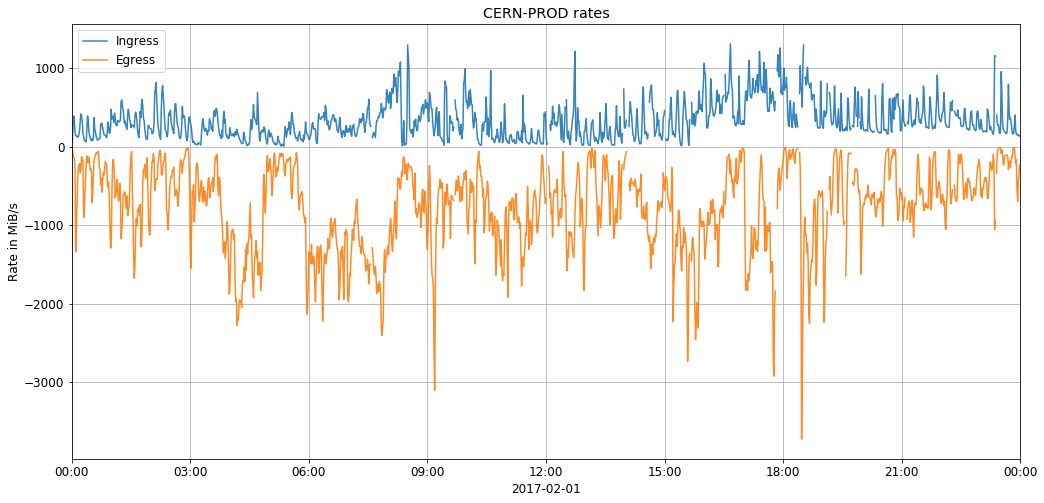

In [11]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
#fig, ax = plt.subplots()
plt.title('CERN-PROD rates')
plt.plot(date_index, np.array(dst_rate['CERN-PROD'])/(1024*1024),'', alpha=0.9, label='Ingress')
plt.plot(date_index, -np.array(src_rate['CERN-PROD'])/(1024*1024),'', alpha=0.9, label='Egress')
#plt.yscale('log')
plt.xlim(dt.datetime.utcfromtimestamp(delta),dt.datetime.utcfromtimestamp(delta+24*60*60))
#plt.ylim(-100,100)
plt.xlabel(DATE)
plt.ylabel('Rate in MiB/s')
ax=plt.gca()
xfmt = mdates.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(xfmt)
fig = plt.gcf()
fig.set_size_inches(17, 8)
plt.legend()
plt.grid()
plt.show()

In [10]:
for x,y in zip(date_index,np.array(link_rate['BNL-ATLAS__CERN-PROD'])/(1024*1024)):
    print(x,y)

2017-02-01 00:00:00 0.0
2017-02-01 00:01:00 0.0
2017-02-01 00:02:00 51.4733449313
2017-02-01 00:03:00 51.4733449313
2017-02-01 00:04:00 26.7884305172
2017-02-01 00:05:00 6.20523995956
2017-02-01 00:06:00 1.10514149666
2017-02-01 00:07:00 5.61664958
2017-02-01 00:08:00 4.36087828477
2017-02-01 00:09:00 4.75453162988
2017-02-01 00:10:00 1.65864559809
2017-02-01 00:11:00 0.0
2017-02-01 00:12:00 0.0
2017-02-01 00:13:00 21.0930046558
2017-02-01 00:14:00 8.31989506086
2017-02-01 00:15:00 2.0668334643
2017-02-01 00:16:00 2.0668334643
2017-02-01 00:17:00 2.0668334643
2017-02-01 00:18:00 2.0668334643
2017-02-01 00:19:00 0.0
2017-02-01 00:20:00 0.0
2017-02-01 00:21:00 0.0
2017-02-01 00:22:00 0.0
2017-02-01 00:23:00 18.0919355286
2017-02-01 00:24:00 24.1687518173
2017-02-01 00:25:00 18.1887466007
2017-02-01 00:26:00 0.0
2017-02-01 00:27:00 0.0
2017-02-01 00:28:00 0.0
2017-02-01 00:29:00 0.0
2017-02-01 00:30:00 0.0161756833394
2017-02-01 00:31:00 0.0
2017-02-01 00:32:00 0.0
2017-02-01 00:33:00 10.